In [1]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import time
import random
from PIL import Image
import albumentations as A
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature

## Getting the Data

In [4]:
!pip install -q kaggle

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [4]:
!chmod 600 ~/.kaggle

In [11]:
!mkdir .kaggle/
!cp kaggle.json .kaggle/

mkdir: cannot create directory ‘.kaggle/’: File exists


In [14]:
!ls

Human_Eotion_detection.ipynb  kaggle.json


In [17]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

/bin/bash: kaggle: command not found


In [ ]:
!unzip 'human-emotions-datasethes.zip' -d 'dataset/'

In [20]:
!rm human-emotions-datasethes.zip

## Getting a training and testing dataset

In [2]:
train_dir = 'dataset/Emotions Dataset/Emotions Dataset/train'
val_dir = 'dataset/Emotions Dataset/Emotions Dataset/test'
CLASS_NAMES = ['angry', 'happy', 'sad']

In [3]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 100,
    "N_DENSE_2": 10,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

## Dataset Loading

In [4]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION['CLASS_NAMES'],
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99
)

Found 6799 files belonging to 3 classes.


In [5]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [6]:
len(train_dataset)

213

In [7]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=val_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION['CLASS_NAMES'],
    color_mode='rgb',
    batch_size=CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle=True,
    seed=99
)

Found 2278 files belonging to 3 classes.


In [8]:
len(val_dataset)

72

## Dataset Visualization

In [9]:
print('test')

test


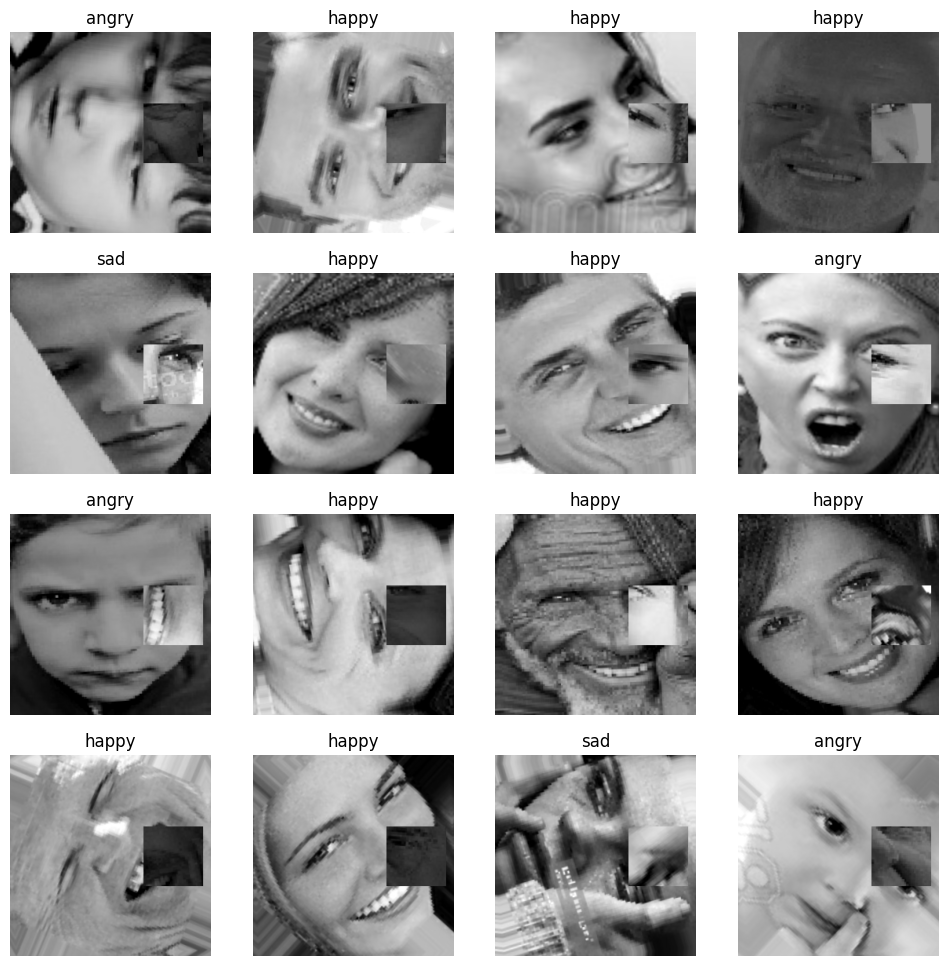

In [17]:
plt.figure(figsize=(12,12))
for image, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(image[i]/255.)
    plt.title(CLASS_NAMES[tf.argmax(labels[i], axis=0).numpy()])
    plt.axis('off')

## Data augmentation

In [11]:
augment_layers = tf.keras.Sequential([
       RandomRotation(factor = (-0.025, 0.025),),
       RandomFlip(mode='horizontal',),
       RandomContrast(factor=0.1),
                                  
])
def augment_layer(image, label):
    return augment_layers(image, training=True), label

### Cutmix augmentation

In [12]:
def box(lamda):
  
  r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFIGURATION["IM_SIZE"])
  r_y = tf.clip_by_value(r_y - r_h//2, 0, CONFIGURATION["IM_SIZE"])

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFIGURATION["IM_SIZE"])
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, CONFIGURATION["IM_SIZE"])

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [13]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(2,2)
  lamda = lamda.sample(1)[0]
  
  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"]), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

In [14]:
train_dataset_1 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [15]:
# for cutmix usage
BATCH_SIZE = 32
train_dataset = (
    mixed_dataset
    .map(cutmix, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

In [16]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

## Dataset Preparation

In [33]:
resize_rescale_layers = tf.keras.Sequential([
       Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
       Rescaling(1./255),
])

In [ ]:
training_dataset =(
    train_dataset
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

In [20]:
validation_dataset =(
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

## Modeling

### Sequential API

In [91]:
IM_SIZE = CONFIGURATION['IM_SIZE']
DROPOUT_RATE = CONFIGURATION['DROPOUT_RATE']
REGULARIZATION_RATE = CONFIGURATION['REGULARIZATION_RATE']
N_FILTERS = CONFIGURATION['N_FILTERS']
KERNEL_SIZE = CONFIGURATION['KERNEL_SIZE']
POOL_SIZE = CONFIGURATION['POOL_SIZE']
N_STRIDES = CONFIGURATION['N_STRIDES']

lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (None, None, 3)),
    resize_rescale_layers,
    Conv2D(filters = N_FILTERS , kernel_size = KERNEL_SIZE, strides = N_STRIDES , padding='valid',
          activation = 'relu',kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2),
    Dropout(rate = DROPOUT_RATE ),

    Conv2D(filters = N_FILTERS*2 + 4, kernel_size = KERNEL_SIZE, strides=N_STRIDES, padding='valid',
          activation = 'relu', kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2),

    Flatten(),

    Dense( CONFIGURATION['N_DENSE_1'], activation = "relu", kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    Dropout(rate = DROPOUT_RATE),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),

    Dense(CONFIGURATION['NUM_CLASSES'], activation = "softmax"),

])

lenet_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 254, 254, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 254, 254, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 127, 127, 6)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 127, 127, 6)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 16)     

## Training

In [92]:
loss_function = CategoricalCrossentropy()

In [93]:
metrics = [CategoricalAccuracy(name = 'accuracy'),TopKCategoricalAccuracy(k= 2, name='top_k_accuracy')]

In [94]:
lenet_model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
    loss= loss_function,
    metrics = metrics
)



In [95]:
history = lenet_model.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs= 10,
    verbose = 1
)

Epoch 1/10
121/213 [================>.............] - ETA: 1:14 - loss: 1.1101 - accuracy: 0.4760 - top_k_accuracy: 0.7794

KeyboardInterrupt: 

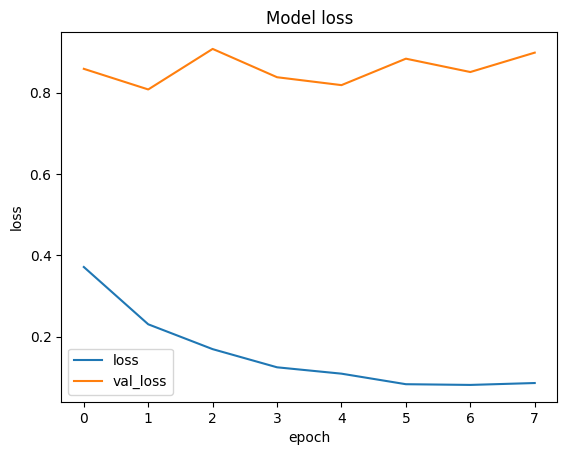

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'])
plt.show()

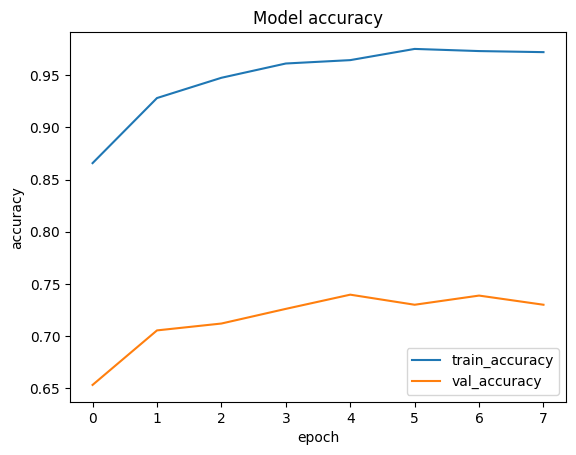

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

## Testing

In [45]:
test_image  = cv2.imread('dataset/Emotions Dataset/Emotions Dataset/train/happy/402929.jpg_rotation_1.jpg')
im = tf.constant(test_image, dtype=tf.float32)
im = tf.expand_dims(im, axis=0)
result = tf.argmax(lenet_model(im), axis=-1).numpy()
print(result)
print(CLASS_NAMES[result[0]])



[1]
happy


TensorShape([1, 224, 224, 3])

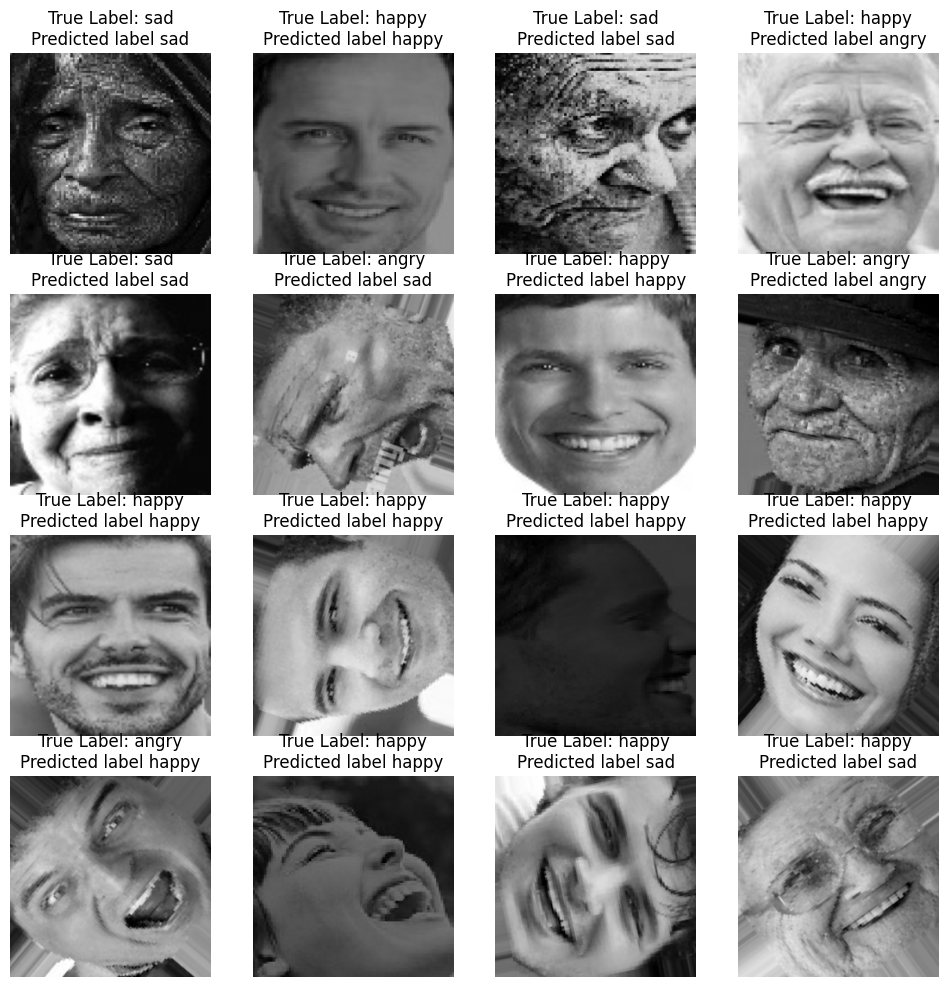

In [59]:
plt.figure(figsize=(12,12))
for image, labels in validation_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(image[i]/255.)
    label = CLASS_NAMES[tf.argmax(labels[i], axis=0).numpy()]
    prediction = CLASS_NAMES[tf.argmax(lenet_model(tf.expand_dims(image[i], axis=0)), axis=-1).numpy()[0]]
    plt.title(f'True Label: {label}\nPredicted label {prediction}')
    plt.axis('off')

## Confusion Matrix

In [66]:
predicted = []
labels  = []
for im, label in validation_dataset:
    predicted.append(lenet_model(im))
    labels.append(label.numpy())
    

In [67]:
print(np.argmax(labels[:-1], axis=-1).flatten())
print(np.argmax(predicted[:-1], axis=-1).flatten())

[0 0 1 ... 2 0 2]
[0 0 2 ... 2 0 2]


In [75]:
pred = np.concatenate([np.argmax(predicted[:-1], axis=-1).flatten(), np.argmax(predicted[-1], axis=-1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis=-1).flatten(), np.argmax(labels[-1], axis=-1).flatten()])

In [76]:
print(len(pred))
print(len(lab))

2278
2278


[[322  76 117]
 [ 67 758 181]
 [ 68 106 583]]


Text(0.5, 58.7222222222222, 'Predicted')

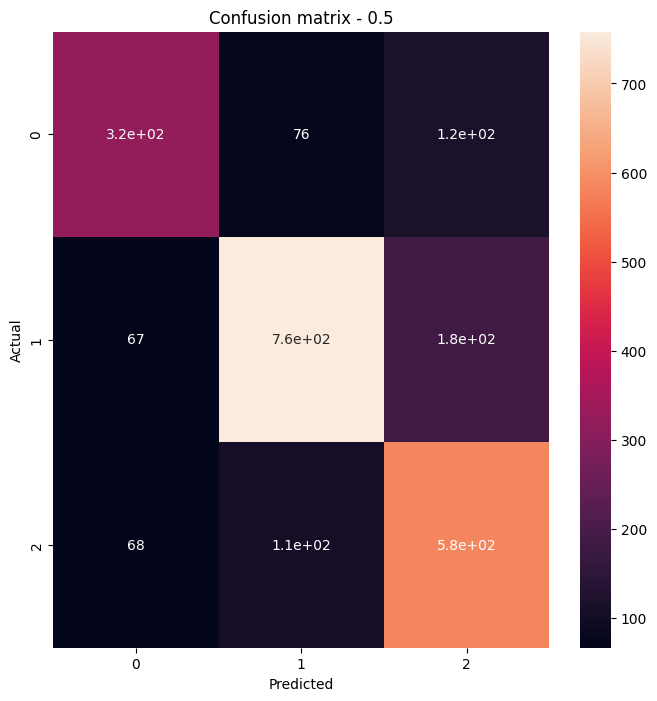

In [77]:
threshold = 0.5

cm = confusion_matrix(lab, pred)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix - {}'.format(threshold))
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [ ]:
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])